In [19]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}


div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
.3
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Objectives

In this note book, I am testing M-H MCMC module.

   - import Metropolis_Hasting as MCMC
   - Using the same exercise in the notebook : Test_NS_with_simple_Gaussian1.0

In [20]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as duplicate
import time
from matplotlib import colors
import scipy as sp

####Import test mcmc module

import Metropolis_Hasting_3_0 as MH3

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

# Likelihood

TODO: I define a Gaussian log-likelihood function given by;

$$\log{L} = {\log{(\frac{1}{\sqrt{2\pi\sigma^{2}}}})}  {-\frac{(\mu_{0} - \mu)^{2}}{2\sigma^{2}}}$$

In [22]:
def logLikelihood(mu,args):
    
    """Simple gaussian Likelihood
    
    Parameters
    --------------
    mu_true : scalar
            True mean value
    mu     : scalar
            sampled mu
    
    *args : list
            Likelihood extra arguments
    """
    
    mu_value = args[0]
    
    
    L = (1/np.sqrt(2*np.pi)*np.exp(-(mu_value-mu)**2))
    
    return np.log(L)

In [23]:
def generate_uniform_values():
    """Generate uniform y values between 0,10"""
    mu = sp.stats.uniform.rvs(0,10)
    
    return mu

# Prior on $\mu$
TODO : Define function of prior on $\mu$

The prior on $\mu$ is a flat prior.
                
$$P(\mu) = \frac{1}{\mu_{upper}-\mu_{lower}}$$

In [24]:
def Prior(mu,args):
    
    
    """Evaluate the prior probability of mu
    
    Parameters
    
    ----------------
    
    mu : scalar
            mean
            
    mu_limits: list or array 
            The limits of mu
            
    *args : list
            prior extra arguments
    
    ----------------
     output: scalar
            The log Prior of mu.
    
    """
    
    mulimits = args[0]
    #If position is out of limits discard 
    if (mu < mulimits[0]) | (mu > mulimits[1]):  
        mu_prior = np.nan
    else:
        mu_prior = 1.0/(mulimits[1] - mulimits[0])
    
    return mu_prior

In [25]:
# Useful function #Compute the log of the sum of exponentials of input elements.
# OR from scipy.misc import logsumexp 

def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result


## Simple Gaussian function with $\mu$ = 5 and $\sigma$ = 1

Text(0.5,0,'$\\mu$')

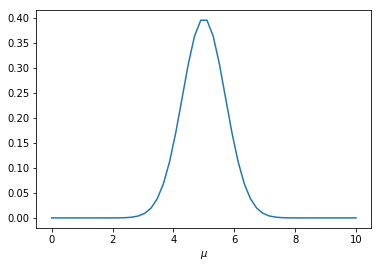

In [158]:
x_vals = np.linspace(0,10)
y_vals = (1/np.sqrt(2*np.pi))*np.exp(-(x_vals-5)**2) #+ (1/np.sqrt(2*np.pi))*np.exp(-(x_vals-8)**2)

plt.plot(x_vals,y_vals)
plt.xlabel('$\mu$')

# Generate walkers

In [165]:
# Generate walkers
N = 550
particles = []

#LIMITS of mu
mulimits = np.array([0,10])
mu_value = np.array([5])

#Likelihood function arguments
args_loglike = [mu_value]

#Prior function arguments
args_prior = [mulimits]

logl = np.array([])
logp = np.array([])

for i in range(0, N):
    mu_val = generate_uniform_values()
    particles.append(mu_val)
    logl = np.append(logl,logLikelihood(mu_val,args_loglike)) 
    logp = np.append(logp,Prior(mu_val,args_prior))

In [166]:
# Number of NS iterations
nest_steps = 20000

# MCMC steps per NS iteration
mcmc_steps = 350

# mcmc stepsize
mustep = 0.4
stepsize = np.array([mustep])

#Number of parameters
num_params = 1



# Storage for results
keep = np.empty((nest_steps, num_params + 1))

nacceptance = np.array([])
nrejectance = np.zeros(nest_steps)



# Main Nest

In [167]:
for i in range(nest_steps):
    
    # Particle with worst likelihood
    worst = np.argmin(logl)   
    
    # Save the details of the worst particle, (likelihood)
    keep[i,:-1] = particles[worst] 
    keep[i,-1] = logl[worst]
    
    # Copy random survivor
    #----copy a random point and do mcmc from there-----
    while True:
        copy = np.random.randint(len(particles))
        if (copy != worst):break
            
    # Throw away worst particle and replace with random particle 
    #and do mcmc from the random particle (will change with new sample)
    particles[worst] = duplicate.deepcopy(particles[copy]) 
    
    particle_new_copy =  particles[worst]
    # Likelihood of worst point
    loglstar = duplicate.deepcopy(logl[worst])
    logpstar = logp[worst]
    
    
    theta = particle_new_copy
    
    #Do mcmc on the survivor particle
    chain_particle , chain_loglike , chain_prior , Acceptance_R = MH3.MH_mcmc(logLikelihood,Prior,\
                                                    theta,args_loglike,args_prior,mcmc_steps,stepsize,\
                                                    Nested_Sampling=True,Nested_Sampling_args=[loglstar,logpstar])
    if chain_loglike[-1]>loglstar:
        logl[worst]      = chain_loglike[-1]
        particles[worst] = chain_particle[-1]
        logp[worst]      = chain_prior[-1]

        #Save acceptance ratio for each mcmc
        nacceptance = np.append(nacceptance,Acceptance_R)

#Prior Mass    
# evalute prior mass
logX = -(np.arange(0, (nest_steps))+ 1.)/N  

# Acceptance Ratio

Text(0,0.5,'Acceptance Ratio')

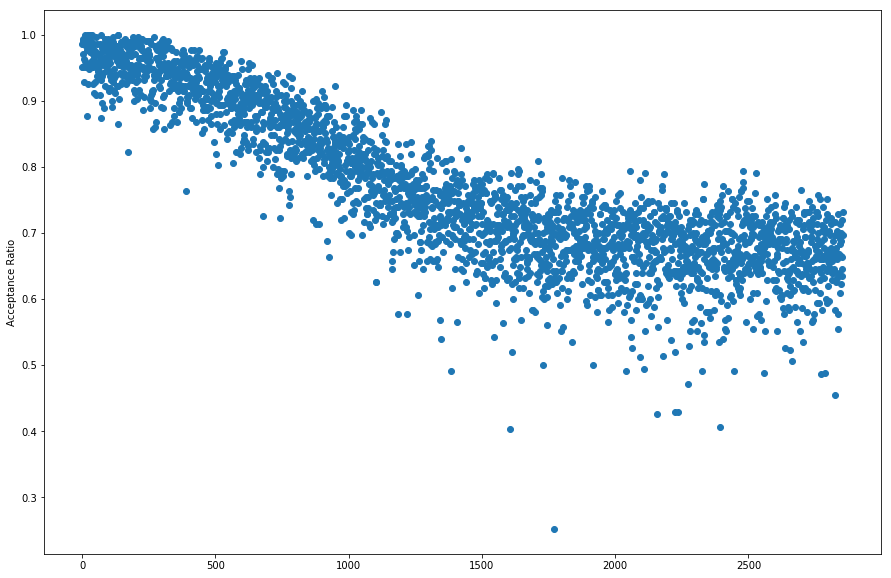

In [168]:
plt.figure(figsize=(15,10))
plt.plot(nacceptance,'o')
plt.ylabel('Acceptance Ratio')

Text(0.5,0,'$\\log(X)$')

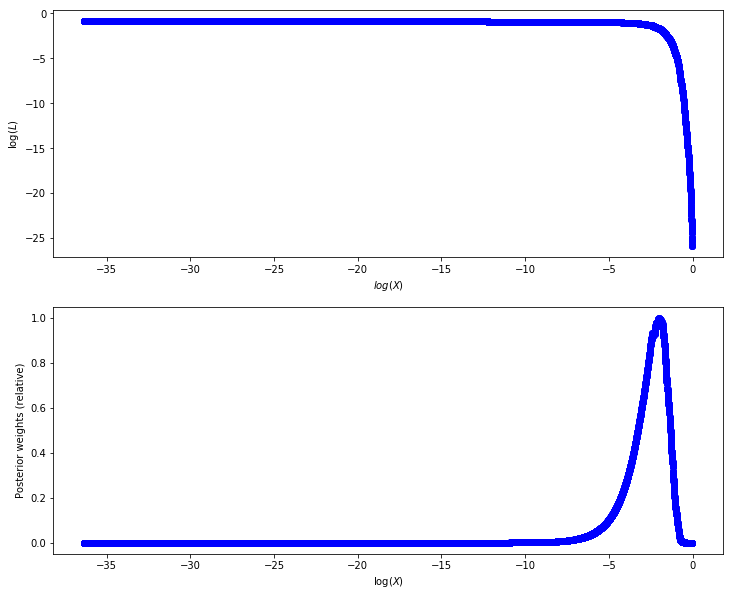

In [169]:
#Visualize Likelihood vs Prior Mass

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(logX, keep[0:(nest_steps), -1], 'bo')
plt.ylabel('$\\log(L)$')
plt.xlabel('$log(X)$')



plt.subplot(2,1,2)

#Posterior weights

logwt = logX.copy() + keep[0:(nest_steps), -1]

# Normalised posterior weights
wt = np.exp(logwt - logwt.max())              
plt.plot(logX, wt, 'bo-')
plt.ylabel('Posterior weights (relative)')
plt.xlabel('$\\log(X)$')

In [170]:
# Prior weights
logw = logX.copy()
# Normalise them
logw -= logsumexp(logw)  

# Calculate marginal likelihood
logZ = logsumexp(logw + keep[:,-1])

# Normalised posterior weights
wt = wt/wt.sum()

effective_sample_size = int(np.exp(-np.sum(wt*np.log(wt + 1E-300))))

# Calculate information
H = np.sum(wt*(keep[:,-1] - logZ))

print('logZ = {logZ} '.format(logZ=logZ))
print('Information = {H}'.format(H=H))
print('Effective Sample Size = {ess}'.format(ess=effective_sample_size))

logZ = -2.91570104351754 
Information = 1.2765139050349845
Effective Sample Size = 2279


# Analytic Solution for Z

$$ Z = \int_{0}^{10}L(\theta)\pi(\theta)d\theta$$
$$ = \int_{0}^{10}\frac{exp(-\theta-5)^{2}}{10\sqrt(2\pi)}d\theta $$
$$ = \frac{erf(5)}{10\sqrt(2)}$$

$$ Z_{analytic} = 0.0707$$


# Comparison of the LogZ from Nested sampling and the Analytical solution

In [171]:
print("LogZ_nest  = " + str(logZ) + "\n\n" +"LogZ_analytic = "+ str(np.log(0.0707)))

LogZ_nest  = -2.91570104351754

LogZ_analytic = -2.64930970607961


# Posterior

In [172]:
posterior_samples = np.empty((effective_sample_size, keep.shape[1]))
logX_effective = np.empty(effective_sample_size)
k = 0
while True:
  # Choose one of the samples
    which = np.random.randint(keep.shape[0])

  # Acceptance probability
    prob = wt[which]/wt.max()

    if np.random.rand() <= prob:
        posterior_samples[k, :] = keep[which, :]
        logX_effective[k] = logX[k]
        k += 1

    if k >= effective_sample_size:
        break

#np.savetxt('keep_Many.txt', posterior_samples)

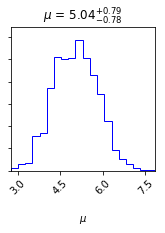

In [173]:
Fig = corner.corner(posterior_samples[:,:-1], labels=['$\mu$'],bins=20,show_titles=True,color='b',smooth=1.0);

/home/hope-moloko/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.7,0.9,'Blue Histogram : NS Posterior \n\n Orange : True Posterior ')

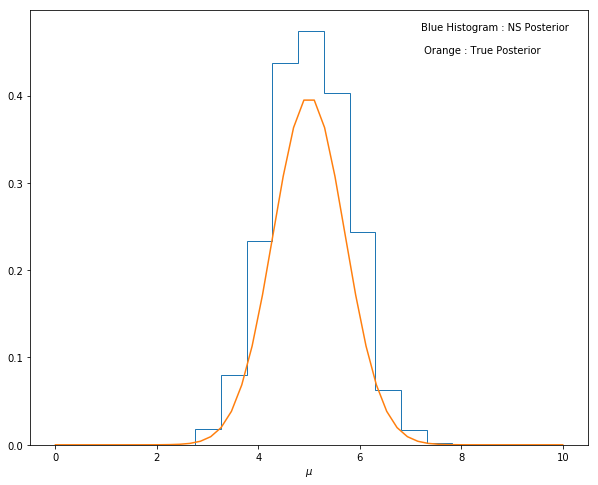

In [176]:
plt.figure(figsize=(10,8))
plt.hist(posterior_samples[:,:-1],normed=True,histtype='step');
plt.plot(x_vals,y_vals)
plt.xlabel('$\mu$')
plt.annotate("Blue Histogram : NS Posterior \n\n Orange : True Posterior ",xy=(0.7,0.9),xycoords="axes fraction")


# LogZ Distribution

In [156]:
logZ_distribution = []  #Empty list to store logZ
NZ = 5000               # LlogZ sample size

for i in range(NZ):   # Samples size
    uniform_numbers = np.log(np.random.uniform(0,1,len(keep[:,-1])))  #Generate log uniform numbers (log space)
    number_new = 0                                                    #initialize number
    logX_mass = []                                                    #store each prior mass

    for number in uniform_numbers:                                    # for each log uniform number
    
        number_new -= number                                         # x1,x2,x3 = u1,u1*u2,u1*u2*u3 etc. in log space we add
        logX_mass.append(-number_new/N)                              # store each logx..

    logw_un = logX_mass                                             #prior weights
    logw_un -= logsumexp(logw_un)                                   #normalise them

    logZ_un = logsumexp(logw_un + keep[:,-1])                        #Evaluate logZ 
    
    logZ_distribution.append(logZ_un)                                #store each logZ 
    

/home/hope-moloko/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


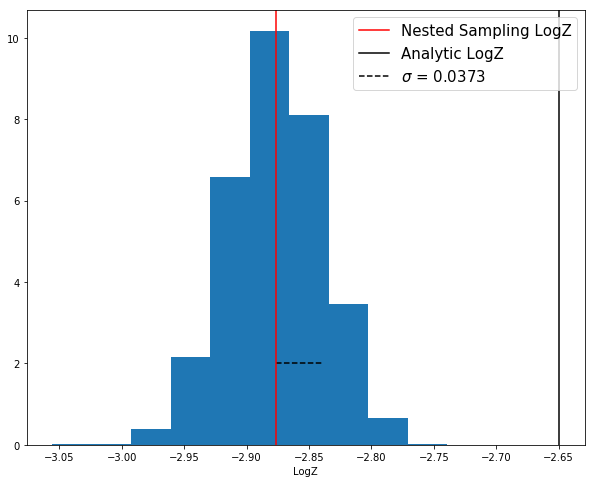

In [157]:
std = np.std(logZ_distribution)    # Standard deviation of logZ distribution

fig,ax = plt.subplots(figsize=(10,8))

ax.hist(logZ_distribution,normed=True);
ax.axvline(logZ,c='r',label = 'Nested Sampling LogZ')
ax.axvline(np.log(0.0707),c='k',label='Analytic LogZ')
ax.set_xlabel('LogZ')
ax.axes.hlines(2,logZ,logZ+std,linestyle='dashed',label='$\sigma$ = ' +str(np.round(std,4)))
ax.legend(fontsize=15)